# [프로젝트] 의도 분류 기반 RAG 수행하기 (Part 1)

![Image](https://github.com/user-attachments/assets/3d4eb6a8-6533-4d7d-b9db-f861b064ac47)

일반적으로, 하나의 RAG 어플리케이션은 여러 개의 DB에 접속하도록 구성됩니다.   
각 DB에 적합한 Loader/Retriever를 구성하고,  
질문별로 적절한 검색을 통해 RAG를 수행하는 Workflow를 만들어 봅시다.   

이번 프로젝트의 데이터 구성은 다음과 같습니다:   
rag.zip 파일을 업로드해 주세요.

<br><br>
rag/templates/*.md : 사내 문서 작성을 위한 양식 목록 (markdown)       
rag/company_policies.pdf : 사내 규정 파일 (PDF)    
rag/employee_data.csv : 사내 구성원 정보(CSV)   

**벡터 데이터베이스 실행을 위해, T4 GPU를 설정해 주세요!**

In [ ]:
!pip install unstructured pymupdf langgraph langchain langchain_google_genai google_generativeai langchain_community langchain-huggingface langchain-chroma python-dotenv sentence_transformers -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 981.5/981.5 kB 36.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 4.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.3/67.3 kB 5.5 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 77.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 20.0/20.0 MB 92.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 136.5/136.5 kB 11.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.0/42.0 kB 3.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 89.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 54.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 611.1/611.1 kB 44.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━

**설치 후 런타임 --> 세션 다시 시작 해 주세요!**

이번 실습에서는 API 키를 입력하는 대신에,    
.env 파일에서 API 키를 불러옵니다.   
실제 API 키를 다음과 같이 넣어주세요!   

```
GOOGLE_API_KEY= 'AIzaSyAxxxxx'
LANGCHAIN_API_KEY='lsv2_pt_f3d94440f7d045c0a8dbe1f----'
```

**.env 파일은 숨김 파일이므로, 오른쪽 파일 탭의 눈(Eye) 표시를 클릭하시면 보입니다 :)**

업로드한 파일의 압축을 해제합니다.

In [ ]:
import zipfile

with zipfile.ZipFile('rag.zip', 'r') as zip_ref:
    zip_ref.extractall('.')

LLM과 임베딩 모델을 설정합니다.

In [ ]:
import os
from langchain_google_genai import ChatGoogleGenerativeAI
from langchain_huggingface import HuggingFaceEmbeddings
from dotenv import load_dotenv

# .env 파일 로드
load_dotenv()

os.environ['LANGCHAIN_PROJECT'] = 'LangGraph_FastCampus'
os.environ['LANGCHAIN_ENDPOINT'] = 'https://api.smith.langchain.com'
os.environ['LANGCHAIN_TRACING_V2']='true'

# 모델 설정
llm = ChatGoogleGenerativeAI(
    model="gemini-2.0-flash",
    temperature=0.1
)

# 임베딩 모델 설정 (실제로 활용하실 때는 더 큰 임베딩 모델이 좋습니다!)
embeddings = HuggingFaceEmbeddings(
    model_name="intfloat/multilingual-e5-small"
)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


modules.json:   0%|          | 0.00/387 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/498k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/57.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/655 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/471M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/443 [00:00<?, ?B/s]

sentencepiece.bpe.model:   0%|          | 0.00/5.07M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/17.1M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/167 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/200 [00:00<?, ?B/s]

In [ ]:
from typing import TypedDict, List, Dict, Any, Optional, Literal
from pydantic import BaseModel, Field

from langgraph.graph import StateGraph, START, END

from langchain_chroma import Chroma
from langchain.prompts import ChatPromptTemplate
from langchain_community.document_loaders import PyMuPDFLoader, CSVLoader, DirectoryLoader
from langchain.text_splitter import RecursiveCharacterTextSplitter

class IntentResult(BaseModel):
    explanation: str
    intent: Literal["policy", "user", "form"] = Field(
        description="사용자 질의의 의도를 저장합니다")

# State 정의
class State(TypedDict):
    query: str  # 사용자 질의
    intent: str  # 의도 분류 결과
    context: List[str]  # RAG 검색 결과
    response: str  # 최종 응답
    error: Optional[str]  # 에러 메시지
    should_end: bool  # 워크플로우 종료 여부


# VectorStore 설정
def create_vectorstore(collection_name: str) -> Chroma:
    return Chroma(
        persist_directory="./chroma_db",
        embedding_function=embeddings,
        collection_name=collection_name
    )


리트리버를 설정합니다.   
기존의 Sematic Search와 함께,  `kiwi` 형태소 분석기를 연결하여   
Hybrid Search를 적용합니다

In [ ]:
!pip install kiwipiepy rank_bm25

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 34.7/34.7 MB 23.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.6/3.6 MB 96.6 MB/s eta 0:00:00
  Created wheel for kiwipiepy_model: filename=kiwipiepy_model-0.20.0-py3-none-any.whl size=34818026 sha256=415dc2077b20ef044a46e296c7503a8839eedde1ab924ec1e400bac984446585
  Stored in directory: /root/.cache/pip/wheels/ca/c8/52/3a539d6e9065b191fe1c215e0203dcc3e00601c0e3d3d39824
Successfully built kiwipiepy_model


In [ ]:
from kiwipiepy import Kiwi
# kiwi 형태소 분석기 설정
kiwi = Kiwi()
def kiwi_tokenize(text):
    return [token.form for token in kiwi.tokenize(text)]

벡터 DB를 생성하고, 파일의 내용을 추가합니다.

In [ ]:
import json
import os
from langchain.retrievers import BM25Retriever, EnsembleRetriever
import uuid
from langchain.schema import Document

def load_data():
    # 3000/300 청킹: 데이터에 따라 조정
    text_splitter = RecursiveCharacterTextSplitter(
        chunk_size=3000,
        chunk_overlap=300,
    )

    policy_file = './rag/company_policies.pdf'
    print(f"[{policy_file}] 문서 로드 중...")

    # 벡터스토어 업데이트
    policy_vectorstore =  Chroma(
    persist_directory="./chroma_db_policy_"+str(uuid.uuid4())[:5],
    embedding_function=embeddings,
    collection_name="policy_collection"
    )
    docs = PyMuPDFLoader(policy_file).load()
    split_docs = text_splitter.split_documents(docs)
    policy_vectorstore.add_documents(split_docs)
    print(f"[{policy_file}] 청킹 완료: {len(split_docs)}개의 청크로 분할됨")


    # 벡터 + BM25 리트리버 생성 (Top 5)
    policy_vector_retriever = policy_vectorstore.as_retriever(search_kwargs={"k": 5})
    policy_bm25_retriever = BM25Retriever.from_documents(split_docs,
                                                          preprocess_func=kiwi_tokenize)
    policy_bm25_retriever.k = 5

    # 하이브리드 리트리버 생성
    policy_retriever = EnsembleRetriever(
        retrievers=[policy_bm25_retriever, policy_vector_retriever],
        weights=[0.5, 0.5]
    )
    print(f"[{policy_file}] 하이브리드 검색 설정됨")


    ###############


    # 사용자 정보 처리
    user_file = './rag/employee_data.csv'
    print(f"[{user_file}] 문서 로드 중...")


    try:
        docs = CSVLoader(user_file).load()
    except:
        docs = CSVLoader(user_file, encoding='cp949').load()
    # CSV 파일의 경우, 하나의 document가 작으므로 결합하여 청킹
    hr_info = Document(page_content="사용자 정보:")
    for doc in docs:
        hr_info.page_content += f"\n{doc.page_content}+\n"


    # 짧은 맥락으로 이해 가능한 경우, 청크 크기 줄이기
    text_splitter = RecursiveCharacterTextSplitter(
        chunk_size=2000,
        chunk_overlap=200,
    )

    split_docs = text_splitter.split_documents([hr_info])

    # 벡터 DB 생성
    user_vectorstore =  Chroma(
    persist_directory="./chroma_db_user_"+str(uuid.uuid4())[:5],
    embedding_function=embeddings,
    collection_name="user_collection"
    )

    print(f"[{user_file}] 청킹 완료: {len(split_docs)}개의 청크로 분할됨")

    # 벡터 + BM25 리트리버 생성 (Top 5)
    user_vector_retriever = user_vectorstore.as_retriever(search_kwargs={"k": 5})
    user_bm25_retriever = BM25Retriever.from_documents(split_docs, preprocess_func=kiwi_tokenize)
    user_bm25_retriever.k = 5

    # 하이브리드 리트리버 생성
    user_retriever = EnsembleRetriever(
        retrievers=[user_bm25_retriever, user_vector_retriever],
        weights=[0.7, 0.3]
        # 이름 등의 고유명사가 중요한 경우 BM25 가중치 높임
    )

    print(f"[{user_file}] 하이브리드 검색 설정됨")

    # 양식 템플릿 처리
    form_dir = './rag/templates'
    print(f"[{form_dir}] 문서 로드 중...")

    docs = DirectoryLoader(form_dir, glob="*.md").load()
    print(f"[{form_dir}] 문서 로드 완료")

    # 벡터 DB 생성
    form_vectorstore =  Chroma(
    persist_directory="./chroma_db_form_"+str(uuid.uuid4())[:5],
    embedding_function=embeddings,
    collection_name="form_collection"
    )

    # 벡터 리트리버 생성
    form_vector_retriever = form_vectorstore.as_retriever(search_kwargs={"k": 4})

    # BM25 리트리버 생성
    form_bm25_retriever = BM25Retriever.from_documents(docs, preprocess_func=kiwi_tokenize)
    form_bm25_retriever.k = 4

    # 하이브리드 리트리버 생성
    form_retriever = EnsembleRetriever(
        retrievers=[form_bm25_retriever, form_vector_retriever],
        weights=[0.5, 0.5]
    )
    print(f"[{form_dir}] 하이브리드 검색 설정됨")

    # 리트리버 맵 반환
    return {
        "policy": policy_retriever,
        "user": user_retriever,
        "form": form_retriever
    }

# 2. 데이터 로드 및 리트리버 생성
retriever_map = load_data()

[./rag/company_policies.pdf] 문서 로드 중...
[./rag/company_policies.pdf] 청킹 완료: 16개의 청크로 분할됨
[./rag/company_policies.pdf] 하이브리드 검색 설정됨
[./rag/employee_data.csv] 문서 로드 중...
[./rag/employee_data.csv] 청킹 완료: 6개의 청크로 분할됨
[./rag/employee_data.csv] 하이브리드 검색 설정됨
[./rag/templates] 문서 로드 중...
[./rag/templates] 문서 로드 완료
[./rag/templates] 하이브리드 검색 설정됨


검색과 답변 모듈을 구성합니다.

In [ ]:
# DB 검색
def retrieve_context(state: State) -> State:

    query = state['query']
    intent = state['intent']

    # 의도에 따른 Retriever 선택
    retriever = retriever_map.get(intent)
    if not retriever:
        state['error'] = f"Unknown intent: {intent}"
        return state

    results = retriever.invoke(query)

    state['context'] = [doc.page_content for doc in results]
    return state

def generate_response(state: State) -> State:
    """검색 결과를 바탕으로 응답 생성"""
    prompt = ChatPromptTemplate([
        ("system", "다음 정보를 바탕으로 사용자의 질의에 답변해주세요. 답변은 친절하고 명확하게 작성해주세요."),
        ("user", """
        질의: {query}
        의도: {intent}
        검색 결과:
        {context}
        """)
    ])

    chain = prompt | llm
    response = chain.invoke({
        "query": state['query'],
        "intent": state['intent'],
        "context": "\n".join(state['context'])
    })

    state['response'] = response.content
    state['should_end'] = True
    return state

의도 분류 모듈을 작성합니다. IntentResult를 통해 간단히 구현합니다.

In [ ]:
# 의도 분류
def classify_intent(state: State) -> State:
    """사용자 질의 의도 분류"""
    prompt = ChatPromptTemplate([
        ("system", "사용자의 질의 의도를 분류해주세요."),
        ("user", "질의: {query}")
    ])

    chain = prompt | llm.with_structured_output(IntentResult)
    result = chain.invoke({"query": state['query']})
    state['intent'] = result.intent
    return state

Workflow의 라우터를 구성합니다.   
만약, 오류가 발생한 경우 에러 처리를 수행합니다.

In [ ]:
def handle_error(state: State) -> State:
    """에러 처리"""
    if state.get('error'):
        state['response'] = f"죄송합니다. 오류가 발생했습니다: {state['error']}"
        state['should_end'] = True
    return state

def should_continue(state: State) -> List[str]:
    """워크플로우 계속 진행 여부 확인"""
    if state.get('error'):
        return 'handle_error'
    if state.get('should_end'):
        return 'END'
    return 'generate_response'

그래프를 만들고, Compile합니다.

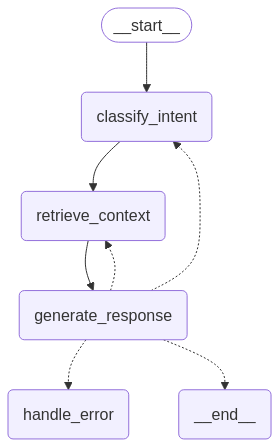

In [ ]:
# 워크플로우 그래프 구성
builder = StateGraph(State)

# 노드 추가
builder.add_node('classify_intent', classify_intent)
builder.add_node('retrieve_context', retrieve_context)
builder.add_node('generate_response', generate_response)
builder.add_node('handle_error', handle_error)

# 엣지 연결
builder.add_edge(START,'classify_intent')
builder.add_edge('classify_intent', 'retrieve_context')
builder.add_edge('retrieve_context', 'generate_response')
builder.add_conditional_edges(
    'generate_response',
    should_continue
)

# 시작 노드 설정


# 그래프 컴파일
graph = builder.compile()

graph

의도를 분류하여, 적절한 DB 검색을 수행하여 답변할 수 있습니다.   


In [ ]:
import pprint
test_queries = [
    "회사의 휴가 정책에 대해 알려주세요",
    "김지훈 직원의 스킬셋이 뭔가요?",
    "휴가신청서 양식을 보여주세요",
]

for query in test_queries:
    result = graph.invoke({'query': query})
    print('Query:', result['query'],'\nIntent:', result['intent'], "\nResult:", result['response'])
    print('\n'+"-" * 50+'\n')

Query: 회사의 휴가 정책에 대해 알려주세요 
Intent: policy 
Result: 안녕하세요. 휴가 정책에 대해 문의주셨습니다.

현재 회사의 휴가 정책은 다음과 같습니다.

**1.2 휴가 정책**

*   **연차휴가**

    *   1년 근속 시 15일 부여
    *   3년 이상 근속 시 1년당 1일 추가 (최대 25일)
    *   분기별 최소 1회 이상 사용 권장
    *   미사용 연차 보상: 통상임금 기준 지급
*   **반차제도**

    *   오전반차(09:00-13:00), 오후반차(13:00-18:00)
    *   2시간 단위 시간연차 사용 가능
*   **경조사 휴가**

    *   본인 결혼: 5일
    *   자녀 결혼: 1일
    *   부모/배우자 사망: 5일
    *   조부모/형제자매 사망: 3일
*   **특별 휴가**

    *   출산전후 휴가: 90일
    *   배우자 출산휴가: 10일
    *   난임치료휴가: 연간 3일
    *   자녀 돌봄 휴가: 연간 10일

궁금한 점이 있으시면 언제든지 다시 문의해주세요.

--------------------------------------------------

Query: 김지훈 직원의 스킬셋이 뭔가요? 
Intent: user 
Result: 김지훈 직원의 스킬셋은 다음과 같습니다: Python, Java, AWS, Kubernetes.

--------------------------------------------------

Query: 휴가신청서 양식을 보여주세요 
Intent: form 
Result: 아래는 휴가신청서 양식입니다.

**휴가신청서**

**문서번호:** VAC-{YYYY}{MM}{DD}-{SEQ}
**작성일자:** {YYYY}-{MM}-{DD}

**1. 신청자 정보**

*   **소속:** {부서명}/{팀명}
*   **성명:** {성명}
*   **사번:** {사번}
*   **직급:** {직

In [ ]:
import pprint
test_queries = [
    "스킬셋에 Java 가 있는 직원 모두 알려줘.",
]

for query in test_queries:
    result = graph.invoke({'query': query})
    print('Query:', result['query'],'\nIntent:', result['intent'], "\nResult:", result['response'])
    print('\n'+"-" * 50+'\n')

Query: 스킬셋에 Java 가 있는 직원 모두 알려줘. 
Intent: user 
Result: 스킬셋에 Java가 있는 직원은 다음과 같습니다:

*   **E001** (김지훈)

--------------------------------------------------



해당 구조는 RAG는 잘 수행하지만, 아래의 질문에 대해서는 답변하지 못합니다.

In [ ]:
# 여러 개의 RAG가 모두 활용되어야 하는 경우
# + 반복 실행이 필요한 경우

test_queries = [
    "야 나 김지훈인데, 25년 3월 22일부터 26일까지 여행 가게 휴가 신청서 작성해줘.",
    '김지훈 직원 소속과 직급 알려줘.'
]

for query in test_queries:
    result = graph.invoke({'query': query})
    print('Query:', result['query'],'\nIntent:', result['intent'], "\nResult:", result['response'])
    print('\n'+"-" * 50+'\n')

Query: 야 나 김지훈인데, 25년 3월 22일부터 26일까지 여행 가게 휴가 신청서 작성해줘. 
Intent: form 
Result: ## 김지훈님, 휴가 신청서 작성해 드립니다.

아래 내용을 확인하시고, 빠진 부분이나 수정할 부분이 있다면 알려주세요.

**휴가신청서**

문서번호: VAC-{YYYY}{MM}{DD}-{SEQ}  (작성일자는 오늘 날짜로 자동 기입됩니다.)

1.  **신청자 정보**

*   소속: {부서명}/{팀명} (소속 부서 및 팀명을 기입해주세요)
*   성명: 김지훈
*   사번: {사번} (사번을 기입해주세요)
*   직급: {직급} (직급을 기입해주세요)

2.  **휴가 정보**

*   2.1 휴가 유형: 연차 휴가
*   2.2 휴가 기간
    *   시작일: 2025-03-22
    *   종료일: 2025-03-26
    *   사용일수: 5일
*   2.3 휴가 사유: 여행

3.  **업무 인수인계**

*   3.1 인수자 정보
    *   성명: {인수자성명} (업무 인수인계자 성함을 기입해주세요)
    *   직급: {인수자직급} (업무 인수인계자 직급을 기입해주세요)
*   3.2 인수인계 사항: {주요 인수인계 내용} (인수인계할 업무 내용을 상세히 기재해주세요)

4.  **비상연락망**

*   연락처: {휴가 중 연락처} (휴가 중 연락 가능한 연락처를 기입해주세요)
*   위치: {휴가 중 위치} (휴가 중 예상 위치를 기입해주세요)

5.  **결재선**

*   팀장: {팀장명} (서명)
*   인사팀장: {인사팀장명} (서명)
*   대표이사: {대표이사명} (서명)

**참고사항**

*   연차휴가는 최소 3일 전 신청 필수
*   경조사 휴가는 관련 증빙서류 첨부 필수
*   병가는 3일 이상 시 진단서 첨부 필수
*   긴급휴가 시 팀장 유선 보고 후 당일 신청 가능

**작성 팁:**

*   문서번호는 회사 규정에 따라 자동으로 채번되는 양식입니다.
*   휴가 사유

다음 코드에서는, 질문이 주어지면 반복 작업을 통해 문제를 해결하도록 코드를 개선해 보겠습니다.